In [19]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import pickle
import re

In [20]:
PSD_dir = "../../../../../data/test_correlation/data_mahy"
output_path = "/home/imonge/Documents/AIS/compar_glob_amplitude" # Output repository for the plots
hydrophone_number = 1 # choose between 1, 2, 3, 4

In [21]:
# Select stations for the chose hydrophone
if hydrophone_number != 4:
    selected_stations = [f"MAHY0{hydrophone_number}",
                         f"MAHY1{hydrophone_number}",
                         f"MAHY2{hydrophone_number}",
                         f"MAHY3{hydrophone_number}",
                         f"MAHY4{hydrophone_number}",
                         ]
else:
    selected_stations = [f"MAHY0{hydrophone_number}",
                         f"MAHY1{hydrophone_number}",
                         f"MAHY3{hydrophone_number}",
                         f"MAHY4{hydrophone_number}",
                         ]

In [22]:
# Load the PSD data
psds_all = []
for station in selected_stations:
    psd_path = os.path.join(PSD_dir, f"{station}.pkl")
    psds_all.append(pd.read_pickle(psd_path))

# Concatenate psds
psd_df = pd.concat(psds_all).sort_index()

# Change 0 to NaN
psd_df.replace(0, np.nan, inplace=True)

# Change absent data to Nan
full_index = pd.date_range(start=psd_df.index.min(), end=psd_df.index.max(), freq="h")
psd_reindexed = psd_df.reindex(full_index)

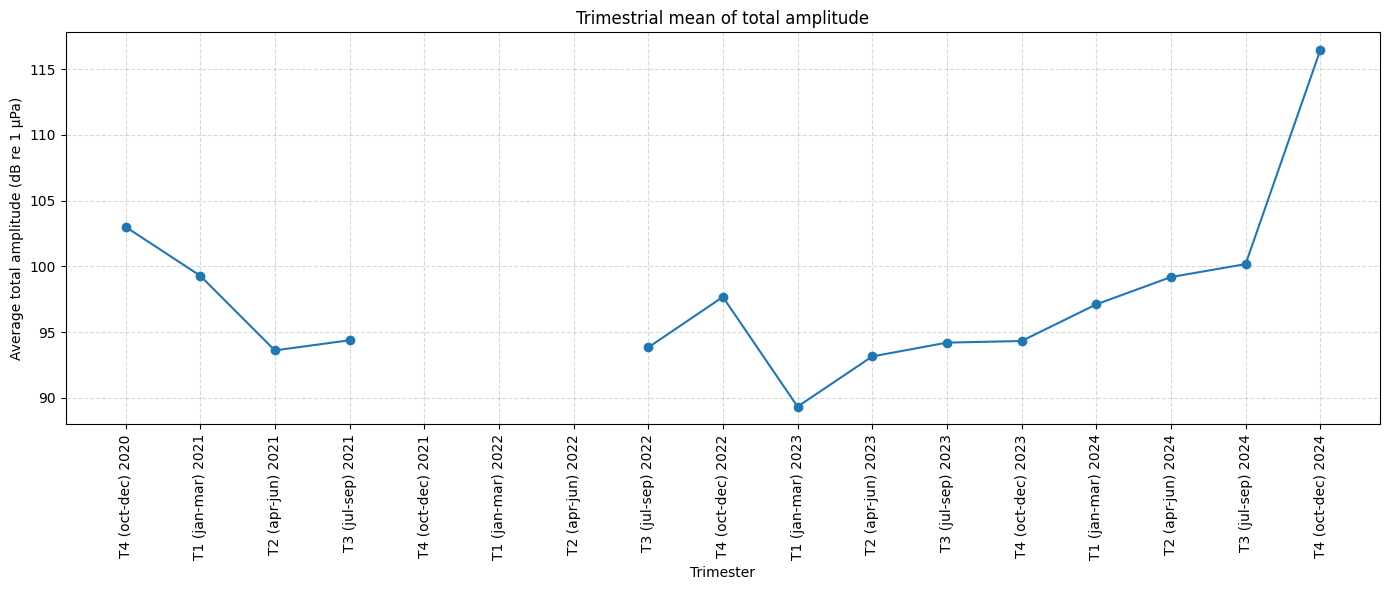

In [24]:
# Global amplitude by trimester -> to match with ship seasonality

psd_total = psd_reindexed.mean(axis=1)
psd_df = psd_total.to_frame(name='total_amplitude')
psd_df['year'] = psd_df.index.year
psd_df['month'] = psd_df.index.month

# Assigne months to trimesters
def assign_trimester(month):
    if month in [1, 2, 3]:
        return 'T1 (jan-mar)'
    elif month in [4, 5, 6]:
        return 'T2 (apr-jun)'
    elif month in [7, 8, 9]:
        return 'T3 (jul-sep)'
    elif month in [10, 11, 12]:
        return 'T4 (oct-dec)'

psd_df['trimester'] = psd_df['month'].apply(assign_trimester)

# Trimestrial mean
quarterly_amplitude = (
    psd_df
    .groupby(['year', 'trimester'])['total_amplitude']
    .mean()
    .reset_index(name='avg_total_amplitude')
)

quarterly_amplitude['avg_total_amplitude'] = 10 * np.log10(quarterly_amplitude['avg_total_amplitude'])

# Create column 'period' for the plot
quarterly_amplitude['period'] = quarterly_amplitude['trimester'] + ' ' + quarterly_amplitude['year'].astype(str)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(quarterly_amplitude['period'], quarterly_amplitude['avg_total_amplitude'], marker='o', label='Quarterly average total amplitude')
plt.title("Trimestrial mean of total amplitude")
plt.xticks(rotation=90)
plt.xlabel("Trimester")
plt.ylabel('Average total amplitude (dB re 1 µPa)')
plt.grid(True, alpha=0.3, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

/tmp/ipykernel_80408/1246972219.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(merged_df['period'], rotation=90)


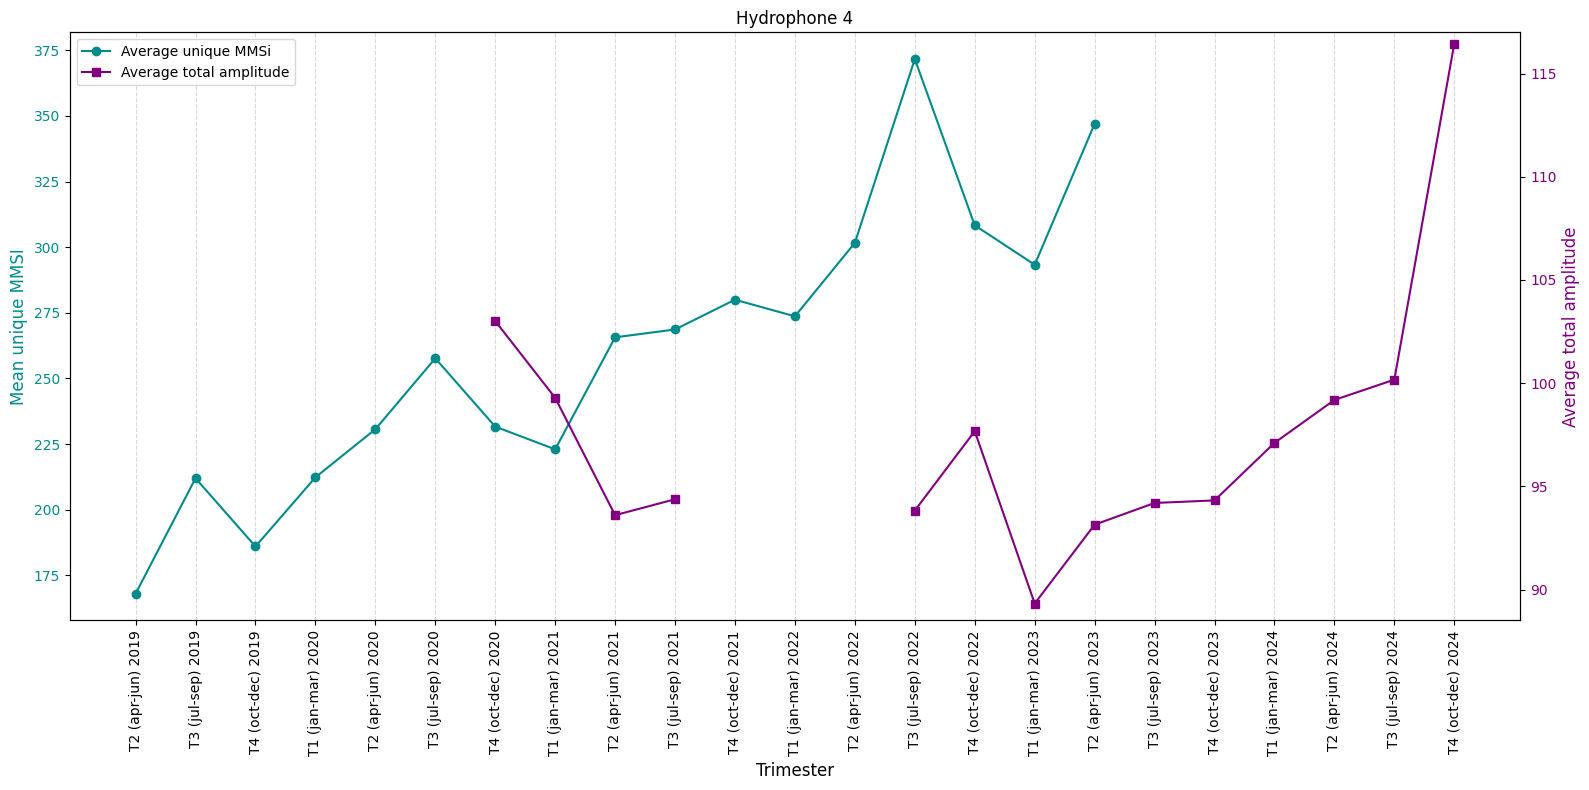

In [25]:
with open('../../../../../data/SPL/quarterly_unique_mmsi.pkl', 'rb') as f:
    final_result = pickle.load(f)

# Outer join (keeps each line of each dataframe)
merged_df = pd.merge(final_result, quarterly_amplitude[['period', 'avg_total_amplitude']], on='period', how='outer')

# Extract years aand trimesters
merged_df['year'] = merged_df['period'].str.extract(r'(\d{4})').astype(int)
merged_df['trimester_number'] = merged_df['period'].str.extract(r't(\d)', flags=re.IGNORECASE)[0].astype(int)


# Sort by date
merged_df = merged_df.sort_values(by=['year', 'trimester_number']).reset_index(drop=True)

# Plot both AIS and amplitude curves
plt.style.use('default')
fig, ax1 = plt.subplots(figsize=(16, 8))

# Left Axis: boat number
ax1.set_xlabel('Trimester', fontsize=12)
ax1.set_ylabel('Mean unique MMSI', color='darkcyan', fontsize=12)
ax1.plot(merged_df['period'], merged_df['avg_unique_mmsi'], color='darkcyan', marker='o', label='Average unique MMSi')
ax1.tick_params(axis='y', labelcolor='darkcyan')
ax1.set_xticklabels(merged_df['period'], rotation=90)
ax1.grid(False)
ax1.grid(True, axis='x', linestyle='--', color='gray', alpha=0.3)

# Right Axis: mean amplitude
ax2 = ax1.twinx()
ax2.set_ylabel('Average total amplitude', color='purple', fontsize=12)
ax2.plot(merged_df['period'], merged_df['avg_total_amplitude'], color='purple', marker='s', label='Average total amplitude')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.grid(False)
ax2.set_ylim(88.5,117)

# Title
plt.title(f'Hydrophone {hydrophone_number}')

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
# plt.show()

plt.savefig(os.path.join(output_path, f'boat_and_amplitude_h{hydrophone_number}.png'), dpi=300)

In [ ]:
# ## Plot total amplitude in time (for all frequencies)
# psd_total = psd_reindexed.mean(axis=1)
# # psd_total = np.log(psd_total) * 10
#
# # Median filter
# psd_filt = psd_total.rolling(window=30).median()
#
# # Plot
# plt.figure(figsize=(20,8))
# plt.plot(psd_total.index, psd_filt.values, label="Total amplitude of the psd")
#
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# # plt.gca().xaxis.set_major_locator(mdates.DateFormatter('%Y-%m'))
#
# plt.title("Total amplitude in time")
# plt.xlabel("Date")
# plt.ylabel("Sum of amplitude for all frequencies")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# ## Plot total amplitude in time for specified ranges
# fmin = 2
# fmax = 5
# freq_range = (fmin, fmax)
# frequencies = [f for f in psd_df.columns if freq_range[0] <= f <= freq_range[1]]
#
# psd_band = psd_reindexed[frequencies]
# psd_total = psd_band.mean(axis=1)
# psd_total = np.log(psd_total) * 10
#
# # Median filter
# psd_filt = psd_total.rolling(window=40).median()
#
# # Plot
# plt.figure(figsize=(20,8))
# plt.plot(psd_total.index, psd_filt.values, label="Total amplitude of the psd")
#
# # # Darkened blocks
# # for start, end in nan_blocks:
# #     plt.axvspan(start, end, alpha=0.2)
#
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# # plt.gca().xaxis.set_major_locator(mdates.DateFormatter('%Y-%m'))
#
# plt.title(f"Total amplitude in range {fmin}-{fmax} Hz (hydrophone {hydrophone_number})")
# plt.xlabel("Date")
# plt.ylabel("Sum of amplitude for all frequencies")
# plt.ylim(140, 270)
# plt.grid(True)
# plt.tight_layout()
# plt.show()